<a href="https://colab.research.google.com/github/vnprr/CatsVsDogs/blob/main/CatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ściągnięcie danych i przygotowanie dysku

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# imports
import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm.notebook import tqdm
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [3]:
#Przeniesienie pliku do folderu struktury plików collaba

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Programowanie/CatsVsDogs/KaggleToken/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Szybkie skopiowanie zbioru z Kaggle:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

100% 813M/814M [00:40<00:00, 23.4MB/s]
100% 814M/814M [00:40<00:00, 21.2MB/s]


In [5]:
# rozpakowanie zbioru
!unzip -q dogs-vs-cats-redux-kernels-edition.zip

!unzip -q train.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [51]:
!rm test.zip

In [8]:
#Czytanie ścieżek plików - po N_PER_SAMPLE elementów z każdego dla wydajności


N_PER_SAMPLE = 1000
path_cats = glob.glob("train/cat.*.jpg")[: N_PER_SAMPLE]
path_dogs = glob.glob("train/dog.*.jpg")[: N_PER_SAMPLE]

In [ ]:
# #test images

# import cv2
# cat = cv2.imread(path_cats[1])

# from google.colab.patches import cv2_imshow

# for i in range(20):
#   cat = cv2.imread(path_cats[i])
#   cv2_imshow(cat)


In [9]:
# Image statistics collection, calculation of average height and width.

heights = []
widths = []

for path in path_cats + path_dogs:
    # load img
    img = cv2.imread(path)

    # image size
    height, width, channels = img.shape
    heights.append(height)
    widths.append(width)

IMG_HEIGHT = int(np.round(np.mean(heights)))
IMG_WIDTH = int(np.round(np.mean(widths)))

print(IMG_HEIGHT, IMG_WIDTH)

362 403


## Generator obrazków

In [22]:
%pwd
!ls train/cats | wc -l
!ls train/dogs | wc -l

12500
12500


In [23]:
# manage files

import os
import shutil

# path
train_folder = "./train"

# Create subfolders for cats and dogs if they don't exist
os.makedirs(os.path.join(train_folder, "cats"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "dogs"), exist_ok=True)

# Iterate through all files in the "train" folder
for filename in os.listdir(train_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust file extensions if needed
        file_path = os.path.join(train_folder, filename)

        # Move cat images to the "cats" subfolder
        if "cat" in filename.lower():
            shutil.move(file_path, os.path.join(train_folder, "cats"))

        # Move dog images to the "dogs" subfolder
        if "dog" in filename.lower():
            shutil.move(file_path, os.path.join(train_folder, "dogs"))

In [46]:
# take 2500 images for test

# path
test_folder = "./test"

# Create subfolders for cats and dogs if they don't exist
os.makedirs(os.path.join(test_folder, "cats"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "dogs"), exist_ok=True)

# Iterate through all files in the "train" folder
for subdir in os.listdir(train_folder):
    for filename in os.listdir(os.path.join(train_folder, subdir)):
      if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust file extensions if needed
          if filename.split('.')[1] in [str(i) for i in range(10000, 12500)]:
            file_path = os.path.join(train_folder, subdir, filename)
            # Move cat images to the "cats" subfolder
            if "cat" in filename.lower():
                out_path = os.path.join(test_folder, 'cats', filename)
                shutil.move(file_path, out_path)
            # Move dog images to the "dogs" subfolder
            if "dog" in filename.lower():
                out_path = os.path.join(test_folder, 'dogs', filename)
                shutil.move(file_path, out_path)




In [56]:
!ls test/cats | wc -l
!ls test/dogs | wc -l
!ls train/cats | wc -l
!ls train/dogs | wc -l

2500
2500
10000
10000


In [64]:
import cv2
import tensorflow as tf # Import tensorflow

def pf(image):
  image = tf.image.resize_with_pad(image, IMG_WIDTH, IMG_HEIGHT) # Resize and pad images to ensure consistent dimensions
  return image

img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=pf,
    validation_split=0.2
)

#train dataset
BATCH_SIZE = 64
train_ds = img_gen.flow_from_directory(
    "./train",
    target_size=[IMG_WIDTH, IMG_HEIGHT],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary', # Change class_mode to binary
    color_mode='grayscale',
    subset='training'
)

#val dataset
val_ds = img_gen.flow_from_directory(
    "./train",
    target_size=[IMG_WIDTH, IMG_HEIGHT],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary', # Change class_mode to binary
    color_mode='grayscale',
    subset='validation'
)


Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


##Trenowanie modelu

In [80]:
import tensorflow as tf
from tensorflow.keras import models, layers

# build model by using input
model = models.Sequential([
    layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1)),  # input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [81]:
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

#model 2
history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=1024, callbacks=[early])  # pobawić się batch size żeby było szybciej
# history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=2048)  # pobawić się batch size żeby było szybciej

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 222s 851ms/step - accuracy: 0.5004 - loss: 6.0481 - val_accuracy: 0.5210 - val_loss: 0.6926
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 850ms/step - accuracy: 0.5386 - loss: 0.6891 - val_accuracy: 0.5575 - val_loss: 0.6886
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 846ms/step - accuracy: 0.5721 - loss: 0.6779 - val_accuracy: 0.5965 - val_loss: 0.6757
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 845ms/step - accuracy: 0.6036 - loss: 0.6606 - val_accuracy: 0.5957 - val_loss: 0.6767
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 845ms/step - accuracy: 0.6185 - loss: 0.6506 - val_accuracy: 0.6413 - val_loss: 0.6396
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 214s 844ms/step - accuracy: 0.6545 - loss: 0.6179 - val_accuracy: 0.7028 - val_loss: 0.5869
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 846ms/step - accuracy: 0.7172 - loss: 0.5554 - val_accuracy: 0.7117 - val_loss: 0.5861
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 848ms/step - accuracy: 0.7398 -

### Ewaluacja modelu

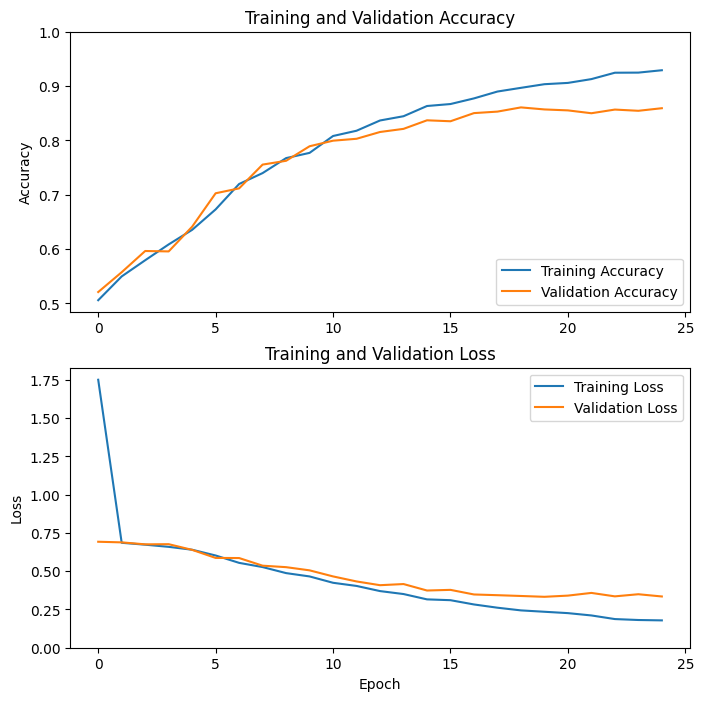

In [85]:
import matplotlib.pyplot as plt

# Get the training history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Create the loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

  9/250 ━━━━━━━━━━━━━━━━━━━━ 2:22 591ms/step - accuracy: 0.9422 - loss: 0.1425

KeyboardInterrupt: 

In [84]:
# Zapisanie modelu
import pickle

model.save('/content/drive/MyDrive/Programowanie/CatsVsDogs/Modele/cat_dog_classifier1_25e.keras')
with open('/content/drive/MyDrive/Programowanie/CatsVsDogs/Modele/cat_dog_classifier1_25e_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## Test modelu

In [87]:
def pf(image):
  image = tf.image.resize_with_pad(image, IMG_WIDTH, IMG_HEIGHT) # Resize and pad images to ensure consistent dimensions
  return image

img_gen_test = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=pf,
)

#train dataset
BATCH_SIZE = 64
test_ds = img_gen_test.flow_from_directory(
    "./test",
    target_size=[IMG_WIDTH, IMG_HEIGHT],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary', # Change class_mode to binary
    color_mode='grayscale',
)


Found 5000 images belonging to 2 classes.


In [88]:
# test model
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 48s 602ms/step - accuracy: 0.8603 - loss: 0.3309
Test Loss: 0.3462967276573181, Test Accuracy: 0.8561999797821045
